## Import lib (C)


In [7]:
# Copyright (c) OpenMMLab. All rights reserved.

import os
import argparse
import yaml
import json
import time

import cv2
import torch
import numpy as np
import pprint
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt

from pre_processing import preprocess
from post_processing import postprocess
from inference import inference_batch_imgs
import configs
from utils import import_class, build_session, prepare_data, draw_skeleton
import sys

sys.path.append('../')
# %matplotlib qt

## Read file (C)


In [8]:
# Read file for mapping (video_id, label, gloss)
json_path = configs.WLASL_JSON_PATH

wlasl_class_list_path = configs.WLASL_CLASS_LIST_PATH


with open(json_path, 'r') as f:
    wlasl2000_json = json.load(f)  # Mapping video id to label


with open(wlasl_class_list_path, mode='r') as f:
    lines = f.readlines()
    label_to_gloss = dict()
    for line in lines:
        data = line.split('\t')
        label = int(data[0])
        gloss = data[1].rstrip()
        label_to_gloss[label] = gloss       # Mapping label to gloss

# # Read video data path
# input_dirs = [
#     r"D:\DATN\project\data\raw_data\rgb\WLASL2000\train\\",
#     r"D:\DATN\project\data\raw_data\rgb\WLASL2000\val\\",
#     r"D:\DATN\project\data\raw_data\rgb\WLASL2000\test\\",
# ]
# paths = []
# for dir_path in input_dirs:
#     path1 = []
#     for root, _, fnames in os.walk(dir_path):
#         for fname in fnames:
#             path0 = os.path.join(root, fname)
#             path1.append(path0)
#     paths.append(path1)

## Load pose estimator model and GCN model (A)


### Configs


In [9]:
# Config area

index_GCN = 2
index_PE = 0        # index_PE = 1 if index_GCN = 1
num_keypoint = 31   # 27 if index_GCN = 0,1 and 31 if index_GCN = 2,3

# -------------------------------- POSE ESTIMATOR CONFIG -------------------------------- #
# onnx_file = r"D:\DATN\project\data_prepare\onnx_model\rtmw-dw-x-l_simcc-cocktail14_270e-384x288_20231122\end2end.onnx"
# onnx_file = r"D:\DATN\project\data_prepare\onnx_model\rtmpose-l_simcc-ucoco_dw-ucoco_270e-256x192-4d6dfc62_20230728\20230831\rtmpose_onnx\rtmpose-l_simcc-ucoco_dw-ucoco_270e-256x192-4d6dfc62_20230728\end2end.onnx"

pe_onnx_paths = configs.PE_ONNX_PATHS
pe_onnx_path = pe_onnx_paths[index_PE]
device = "cpu"

# -------------------------------- GCN MODEL CONFIG -------------------------------- #

# model_config_path = r'D:\DATN\project\Pose-based-WLASL\checkpoints\stgcnpp-27-rtmw_onehot_top1=53.09.yaml'

model_config_paths = configs.MODEL_CONFIG_PATHS
weight_paths = configs.WEIGHT_PATHS

weight_path = weight_paths[index_GCN]
model_config_path = model_config_paths[index_GCN]

print(pe_onnx_path)
print(model_config_path)
print(weight_path)

../onnx_model/rtmw-l+.onnx
../checkpoints/stgcnpp-31-rtmw_onehot_top1=54.66.yaml
../checkpoints/stgcnpp-31-rtmw_onehot_top1=54.66.pt


In [10]:
# # Download HPE ONNX file
# import urllib.request
# import shutil
# import zipfile

# if not os.path.exists(r'..\onnx_model\rtmpose-l.onnx') and not os.path.exists(r'..\onnx_model\rtmw-l+.onnx'):
#     os.makedirs('../onnx_model', exist_ok=True)
#     rtml_url = 'https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/onnx_sdk/rtmpose-l_simcc-ucoco_dw-ucoco_270e-256x192-4d6dfc62_20230728.zip'
#     rtmw_url = 'https://download.openmmlab.com/mmpose/v1/projects/rtmw/onnx_sdk/rtmw-dw-x-l_simcc-cocktail14_270e-384x288_20231122.zip'

#     rtml_name = r'..\onnx_model\rtmpose-l.zip'
#     rtmw_name = r'..\onnx_model\rtmw-l+.zip'
#     # Download
#     print("Download RTMPose-l")
#     urllib.request.urlretrieve(rtml_url, rtml_name)
#     print("Download RTMW")
#     urllib.request.urlretrieve(rtmw_url, rtmw_name)

#     # Extract zip file
#     with zipfile.ZipFile(rtml_name, 'r') as zip_ref:
#         zip_ref.extractall(r'..\onnx_model\rtmpose-l')
#     with zipfile.ZipFile(rtmw_name, 'r') as zip_ref:
#         zip_ref.extractall(r'..\onnx_model\rtmw-l+')

#     # Copy onnx file
    

# # Cleaning
# rtmpose_folder_path = '..\onnx_model\rtmpose-l'
# rtmw_folder_path = '..\onnx_model\rtmw-l+'
# os.remove(rtml_name)
# os.remove(rtmw_name)
# shutil.rmtree(rtmpose_folder_path)
# shutil.rmtree(rtmw_folder_path)

### Load Model from config


In [11]:
# -------------------------------- LOAD POSE ESTIMATOR MODEL -------------------------------- #

# Build session with ONNXRuntime
sess = build_session(pe_onnx_path, device)
print(f"Load pose estimator from ONNX file: {pe_onnx_path}")

h, w = sess.get_inputs()[0].shape[2:]
model_input_size = (w, h)
print(f"Input size of pose estimator ({w},{h})")


# -------------------------------- LOAD GCN MODEL -------------------------------- #

with open(model_config_path) as f:
    arg = yaml.load(f, Loader=yaml.FullLoader)
arg = argparse.Namespace(**arg)

Model = import_class(arg.model)
model = Model(**arg.model_args)
print(f"Load GCN from config: {model_config_path}")

weights = torch.load(weight_path, map_location='cpu')
new_weights = {}
for key, value in weights.items():
    new_weights[key[7:]] = value

model.load_state_dict(new_weights)
model.eval()
print(f"Load GCN weight from: {weight_path}")
print(vars(arg))

Load pose estimator from ONNX file: ../onnx_model/rtmw-l+.onnx
Input size of pose estimator (288,384)
Load GCN from config: ../checkpoints/stgcnpp-31-rtmw_onehot_top1=54.66.yaml
Load GCN weight from: ../checkpoints/stgcnpp-31-rtmw_onehot_top1=54.66.pt
{'Experiment_name': 'st-gcn-pp', 'base_lr': 0.1, 'batch_size': 64, 'eval_interval': 1, 'feeder': 'feeder.feeder.Feeder', 'model': 'model.stgcn_pp.stgcn_pp.Model', 'model_args': {'gcn_adaptive': 'init', 'gcn_with_res': True, 'graph': 'graph.graph.Graph', 'graph_args': {'layout': 'keypoint-31', 'mode': 'spatial'}, 'in_channels': 3, 'num_class': 2000, 'tcn_type': 'mstcn'}, 'model_saved_dir': '/kaggle/working/output/save_models', 'nesterov': True, 'num_epoch': 100, 'num_worker': 2, 'optimizer': 'SGD', 'phase': 'train', 'print_log': True, 'save_interval': 20, 'show_topk': [1], 'start_epoch': 0, 't_max': 100, 'test_batch_size': 64, 'test_feeder_args': {'data_path': '/kaggle/input/skeleton-31-rtm-l-384-288/skeleton-31-rtm-l-384-288/test_data_joi

## Offline prediction from video path


In [12]:
# Sign Language Recognition from video path

def predict_offline(video_path, num_keypoint=27):
    """
    Return:
    gloss, results, total_frames, pose_time, model_time 

    gloss: Text for sign
    results: Output from pose estimator with shape (T,W,H)
    total_frames : length frame of video 
    pose_time: time for pose estimation
    model_time: time for model inference

    """
    print(video_path)
    cap = cv2.VideoCapture(video_path)

    stack_frame = []

    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break
        resized_img, center, scale = preprocess(frame, model_input_size)
        stack_frame.append(resized_img)

    # Time for pose estimation
    stack_frame = np.array(stack_frame, dtype=np.float32)
    total_frames = stack_frame.shape[0]
    print(f"{stack_frame.shape[0]} frames")
    # Stack frame shape:  (34, 256, 192, 3)

    start_time = time.time()
    # inference
    outputs = inference_batch_imgs(sess, stack_frame)
    # postprocessing
    keypoints, scores = postprocess(outputs, model_input_size, center, scale)
    pose_time = time.time() - start_time

    results = np.concatenate((keypoints, scores[:, :, None]), axis=2)

    # keypoints.shape = (56, 133, 2)
    # scores.shape = (56,133, )

    # Data-prepare for GCN model
    data = prepare_data(results, num_keypoint)

    # results.shape: (3, 150, 27, 1)
    data = np.expand_dims(data, axis=0)

    # Predict
    start_time = time.time()
    with torch.no_grad():
        data = torch.Tensor(data)
        predictions = model(data)
    model_time = time.time() - start_time

    label = torch.argmax(predictions)
    gloss = label_to_gloss[int(label)]

    print("pose time:", pose_time)
    print("model inference  time: ", model_time)

    return gloss, results, predictions, total_frames, pose_time, model_time

In [13]:
# Visualize result

def visualize_results(video_path, results, predictions, predict_label, true_label='x',  output_size=(512, 512), display_label=False, save_video=False, replay_fps=15):
    # Pipeline: Replay video, draw results to video, print predict label
    video_id = os.path.basename(video_path).split('.')[0]

    # ----------------------------- Visualize prediction ----------------------------- #
    os.makedirs(configs.SAVE_VISUALIZE_DIR, exist_ok=True)

    output_save_fig = r"{}\score_{}.png".format(
        configs.SAVE_VISUALIZE_DIR,   video_id)

    softmax_layer = nn.Softmax(dim=0)
    probality_each_class = softmax_layer(torch.tensor(predictions)[0]).numpy()
    sort_probality_index = np.argsort(probality_each_class)[-5:]

    # Create scores

    top_label = sort_probality_index[::-1]
    scores = probality_each_class[top_label]
    glosses = [label_to_gloss[index] for index in top_label]
    print(glosses, scores)
    plt.bar(glosses, scores, label='xyz')

    # Add labels and title to the chart
    plt.xlabel('Label')
    plt.ylabel('Score')
    plt.title(f"Predict video with true label = \'{true_label}\'")
    plt.savefig(output_save_fig)
    plt.show()

    # ----------------------------- Display true label ----------------------------- #
    if display_label:
        # Create image display predict text
        predict_img = np.zeros((300, 300, 3), dtype=np.uint8)
        text = predict_label
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        color = (255, 255, 255)  # White color in BGR
        thickness = 2

        text_size = cv2.getTextSize(text, font, font_scale, thickness)[0]
        # Center horizontally
        text_x = (predict_img.shape[1] - text_size[0]) // 2
        # Center vertically
        text_y = (predict_img.shape[0] + text_size[1]) // 2
        cv2.putText(predict_img, text, (text_x, text_y),
                    font, font_scale, color, thickness)
        cv2.imshow("Predict label", predict_img)

        if true_label != 'x':
            # Create image display true text
            true_img = np.zeros((300, 300, 3), dtype=np.uint8)
            text = true_label
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 1
            color = (255, 255, 255)  # White color in BGR
            thickness = 2

            text_size = cv2.getTextSize(text, font, font_scale, thickness)[0]
            text_x = (true_img.shape[1] - text_size[0]
                      ) // 2  # Center horizontally
            text_y = (true_img.shape[0] + text_size[1]
                      ) // 2  # Center vertically
            cv2.putText(true_img, text, (text_x, text_y),
                        font, font_scale, color, thickness)
            cv2.imshow("True label", true_img)

    # ----------------------------- Replay video with skeleton ----------------------------- #
    cap = cv2.VideoCapture(video_path)
    i = 0

    if save_video:
        frames = []
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        fps = replay_fps
        frame_width = frame_height = 256

        output_video_filename = r"{}\skeleton_{}.mp4".format(
            configs.SAVE_VISUALIZE_DIR, video_id)
        output_video1_filename = r"{}\rgb_{}.mp4".format(
            configs.SAVE_VISUALIZE_DIR, video_id)

        selected_index = []
        for i, result in enumerate(results):
            if np.all(result[:, :2] <= 300) and np.all(result[:, :2] >= -50):
                selected_index.append(i)
                frame = np.zeros((256, 256, 3), dtype=np.uint8)
                # Extract frame with not in (x,y)

                frame = draw_skeleton(frame, result, num_keypoint)
                frames.append(frame)

        video_frames = []
        i = 0
        while (cap.isOpened()):
            ret, frame = cap.read()
            if not ret:
                break
            if i in selected_index:
                video_frames.append(frame)
            i += 1
        print(len(video_frames))

        out = cv2.VideoWriter(output_video_filename, fourcc,
                              fps, (frame_width, frame_height))
        for frame in frames:
            out.write(frame)

        out1 = cv2.VideoWriter(output_video1_filename, fourcc,
                               fps, (frame_width, frame_height))

        for frame in video_frames:
            out1.write(frame)

        out.release()
        out1.release()

        print("Save video to ", output_video_filename)
        print("Save video to ", output_video1_filename)

        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        i = 0

        while (True):
            if i == len(frames):
                i = 0
                continue

            frame = frames[i]
            video_frame = video_frames[i]

            frame = cv2.resize(frame, output_size)
            video_frame = cv2.resize(video_frame, output_size)
            time.sleep(1 / replay_fps)
            cv2.imshow("RGB Video", video_frame)
            cv2.imshow("Skeleton Video", frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            i += 1

    else:
        while (cap.isOpened()):
            ret, frame = cap.read()

            if not ret:
                i = 0
                cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
                continue
            frame = draw_skeleton(frame, results[i], num_keypoint)
            frame = cv2.resize(frame, output_size)
            time.sleep(1 / replay_fps)
            cv2.imshow("Video", frame)

            i += 1
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    cap.release()
    cv2.destroyAllWindows()

../data/video_demo\57667.mp4
66 frames
pose time: 15.256780624389648
model inference  time:  0.9833486080169678
thank you     thank you
['thank you', 'thankful', 'good', 'sweet', 'wolf'] [9.9364966e-01 1.4982306e-03 7.7855081e-04 5.2938395e-04 4.5979861e-04]


C:\Users\Quan\AppData\Local\Temp\ipykernel_8124\1356431405.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  probality_each_class = softmax_layer(torch.tensor(predictions)[0]).numpy()


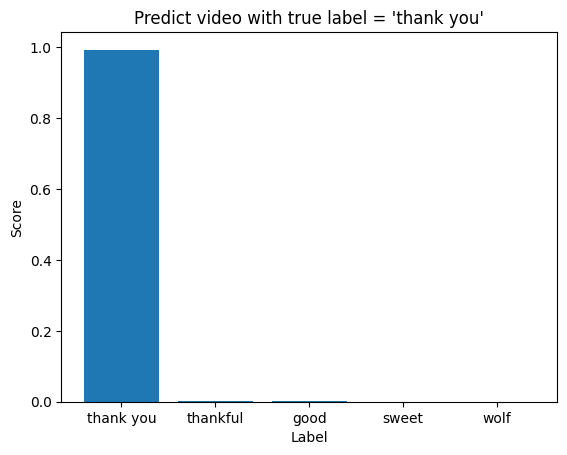

59
Save video to  ../visualize_tmp\skeleton_57667.mp4
Save video to  ../visualize_tmp\rgb_57667.mp4


In [14]:
# 27175, 45721, 57667
video_path = os.path.join(configs.VIDEO_DEMO_PATH, '57667.mp4')

gloss, results, predictions, total_frames, pose_time, model_time = predict_offline(
    video_path, num_keypoint)
video_id = os.path.basename(video_path).split('.')[0]

true_label = wlasl2000_json[video_id]['action'][0]
true_gloss = label_to_gloss[true_label]
print(gloss, '   ', true_gloss)
visualize_results(video_path, results, predictions,
                  gloss, true_gloss, save_video=True)

## Inference time of model


In [15]:
# # Predict video from WLASL2000 folder
# video_paths = paths[2][:20]
# memory = []
# predict_true = 0
# for video_path in video_paths:
#     gloss, results, predictions, total_frames, pose_time, model_time = predict_offline(
#         video_path, num_keypoint)
#     memory.append((total_frames, pose_time, model_time))
#     video_id = os.path.basename(video_path).split('.')[0]
#     true_label = wlasl2000_json[video_id]['action'][0]
#     true_gloss = label_to_gloss[true_label]
#     print(gloss, '   ', true_gloss)
#     if gloss == true_gloss:
#         predict_true += 1

# # Time counting
# memory = np.array(memory)
# sum_up_memory = np.sum(memory, axis=0)
# print("pose time per frame: ", sum_up_memory[1]/sum_up_memory[0])
# print("model time per a inference: ", sum_up_memory[2]/sum_up_memory[0])